In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics





%matplotlib inline

/home/neelima08/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
churn = pd.read_csv("data/churn.csv")

In [ ]:
churn.describe()

In [ ]:
churn.head()

In [3]:
#creating churn column
churn['churn'] = churn['last_trip_date'] < '2014-06-01'
churn = churn.drop(['phone',], axis = 1)

In [4]:
#date treatment
churn['last_trip_date'] = pd.to_datetime(churn['last_trip_date'])
churn['signup_date'] = pd.to_datetime(churn['signup_date'])

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

churn['last_trip_date']= churn['last_trip_date'].apply(to_integer)
churn['signup_date']= churn['signup_date'].apply(to_integer)

In [5]:
#changing true/false to booleans
cols = ['luxury_car_user','churn']
churn[cols] = churn[cols].astype(int)
#creating city dummies
churn = pd.concat([churn, pd.get_dummies(churn.city, prefix='city', drop_first=True)], axis=1)

In [6]:
#filling missing values
churn['avg_rating_by_driver'] = churn['avg_rating_by_driver'].fillna(churn['avg_rating_by_driver'].mean())
churn['avg_rating_of_driver'] = churn['avg_rating_of_driver'].fillna(churn['avg_rating_of_driver'].mean())

In [7]:
columns = list(churn.columns.values)
scaler = StandardScaler()


In [8]:
y = churn["churn"].values
X = churn.drop(["city","churn", "last_trip_date"], axis = 1).values
X = scaler.fit_transform(X)

In [9]:
X_intermed, X_main_test, y_intermed, y_main_test = train_test_split(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_intermed, y_intermed, random_state=0)

In [10]:
def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

In [11]:
def cv(X,y,clf_class,**kwargs):
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [ ]:
GB = GradientBoostingClassifier(n_estimators = 2000, max_features = "sqrt", learning_rate=.03, max_depth = 4)


In [16]:
#print "SVC:", accuracy(y, cv(X,y,SVC))
print "Random_Forest", accuracy(y, cv(X,y, RF))
#print "K-Neighbours", accuracy(y, cv(X,y, KNN))
#print "Logistic", accuracy(y, cv(X, y, LR))
#print "GradientBoostingClassifier", accuracy(y, cv(X,y, GB))

Random_Forest 0.7421


In [ ]:
rf = RandomForestRegressor()
rf.fit(X, y)
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), columns), 
             reverse=True)

In [ ]:
rf1 = RF(n_estimators=13, criterion='entropy', max_depth=10)
accuracy(y, cv(X,y, rf1))

In [ ]:
param_grid = {"max_features":["sqrt"], 'learning_rate': np.linspace(.7, 1.2, 10), "n_estimators": range(200, 600, 100)
   , "max_depth": [2,3,4,5] }
g = GridSearchCV(GradientBoostingClassifier(), param_grid , cv=5, n_jobs = -1).fit(X_train, y_train)
g.best_score_

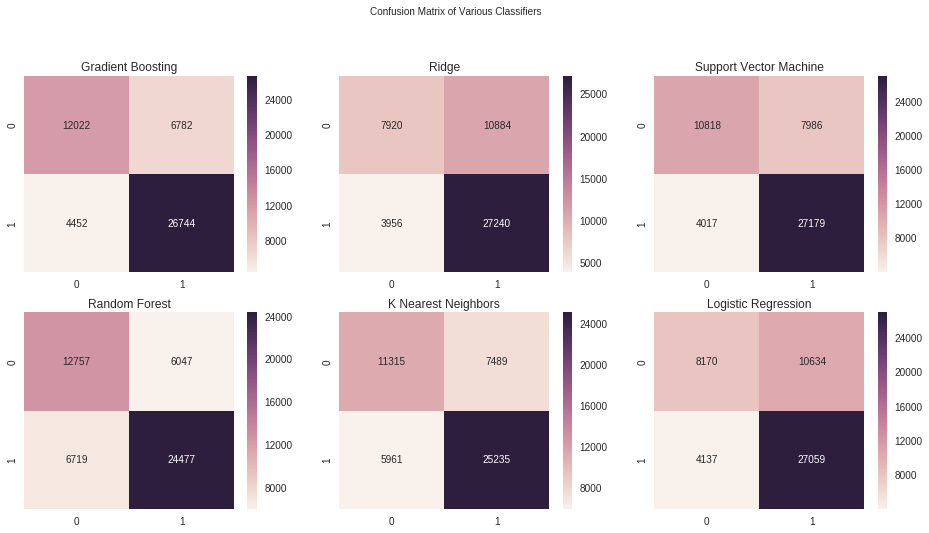

In [13]:
grad_ens_conf_matrix = metrics.confusion_matrix(y, cv(X, y, GB))
ridge_clf_conf_matrix = metrics.confusion_matrix(y, cv(X, y, RidgeClassifier))
svm_svc_conf_matrix = metrics.confusion_matrix(y, cv(X, y, SVC))
random_forest_conf_matrix = metrics.confusion_matrix(y, cv(X, y, RF))
k_neighbors_conf_matrix = metrics.confusion_matrix(y,cv(X, y, KNN))
logistic_reg_conf_matrix = metrics.confusion_matrix(y, cv(X, y, LR))
conf_matrix = {
                
                1: {
                    'matrix': grad_ens_conf_matrix,
                    'title': 'Gradient Boosting',
                   },
                
                2: {
                    'matrix': ridge_clf_conf_matrix,
                    'title': 'Ridge',
                   },
                3: {
                    'matrix': svm_svc_conf_matrix,
                    'title': 'Support Vector Machine',
                   },
                4: {
                    'matrix': random_forest_conf_matrix,
                    'title': 'Random Forest',
                   },
                5: {
                    'matrix': k_neighbors_conf_matrix,
                    'title': 'K Nearest Neighbors',
                   },
                6: {
                    'matrix': logistic_reg_conf_matrix,
                    'title': 'Logistic Regression',
                   }}


fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Confusion Matrix of Various Classifiers')
for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(3, 3, ii) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='');

